In [1]:
from scipy.stats import multivariate_normal, norm, gaussian_kde, rv_continuous
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt
from util_functions import kl_divergence, generate_random_covariance_matrix, plot_sampled_distribution
import random

In [2]:
means = np.random.uniform(low=-2, high=2, size=(2,))
covariance_matrix = generate_random_covariance_matrix(2, low=1, high=5)

means, covariance_matrix

(array([-1.25374999,  0.20700222]),
 array([[6.49307146, 5.8187792 ],
        [5.8187792 , 5.56380502]]))

In [3]:
rv = multivariate_normal(means, covariance_matrix)

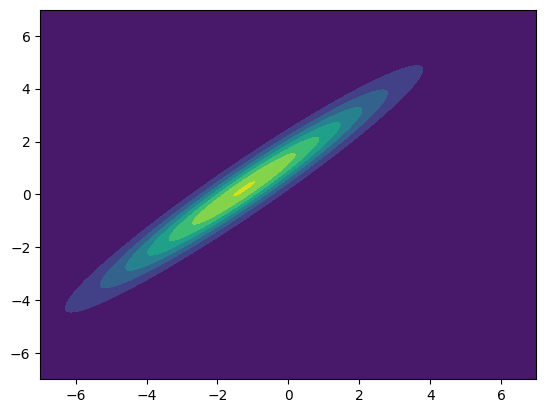

In [4]:
x, y = np.mgrid[-7:7:.01, -7:7:.01]
pos = np.dstack((x, y))

fig2 = plt.figure()
ax2 = fig2.add_subplot(111)

ax2.contourf(x, y, rv.pdf(pos))

In [5]:
def sgnht_sample_multivariate_gaussian_with_covariance(num_samples, theta_init, r_init, eps_init, a, mu, Sigma, eta_0, burn_in=100, thinning=10):
    """
    SGNHT Implementation
    
    Parameters:
    - num_samples: Total number of samples to collect after burn-in.
    - theta_init: Initial value for theta.
    - mu: Mean of the Gaussian distribution.
    - Sigma: Covariance matrix of the Gaussian distribution.
    - eta_0: Initial learning rate (step size).
    - burn_in: Number of initial samples to discard (burn-in period).
    - thinning: Save every 'thinning' sample to reduce correlation between samples.
    
    Returns:
    - samples: Collected samples from the target distribution.
    """
    
    # Initialize theta
    theta = theta_init
    r = r_init
    eps = eps_init
    dim = theta.shape[0]  # Dimensionality of theta 
    samples = []
    
    # Precompute the inverse of the covariance matrix Sigma
    Sigma_inv = np.linalg.inv(Sigma)
    
    # Total iterations needed (including burn-in and thinning)
    total_iterations = burn_in + (num_samples * thinning)
    
    for t in range(1, total_iterations + 1):
        # Learning rate schedule (eta_t = eta_0 / t)
        if t % 10 == 0:
            r = np.random.normal(0, 1, size=(2,))
        eta_t = eta_0 
        
        # Gradient of log p(theta) for multivariate Gaussian N(mu, Sigma)
        grad_log_p_theta = np.dot(Sigma_inv, (theta - mu))
        
        # Noise term: Gaussian noise with variance proportional to eta_t
        noise = np.random.normal(0, eta_t * 2 * a, size=dim)
        
        # SGLD update step
        theta = theta + (eta_t) * r
        #print(r, (eta_t) * grad_log_p_theta, eta_t * r * eps, noise, (r.T @ r)/dim, (r.T @ r)/dim - 1)
        r = r - (eta_t) * grad_log_p_theta - eta_t * r * eps + noise
        #r = np.clip(r, -5, 5)
        eps = eps + eta_t * ((r.T @ r)/dim - 1)
        #eps = np.clip(eps, -5, 5)
        
        # After burn-in, save samples with thinning
        if t > burn_in and (t - burn_in) % thinning == 0:
            samples.append(theta.copy())
            #print(theta)
            
    
    return np.array(samples)

In [6]:
# Parameters for the multivariate Gaussian distribution N(mu, Sigma)
mu = means  # Mean vector (non-zero)
Sigma = covariance_matrix  # Covariance matrix
eta_0 = 0.1  # Initial learning rate
theta_init = np.random.randn(2)  # Start with a 2D random point
r_init = np.random.randn(2)
eps_init = 0
a = 1
num_samples = 10000  # Number of samples we want to collect after burn-in

# Run SGLD to sample from N(mu, Sigma)
samples = sgnht_sample_multivariate_gaussian_with_covariance(num_samples=num_samples, 
                                               theta_init=theta_init,
                                               r_init = r_init,
                                               eps_init = eps_init,
                                               a = a,
                                               mu=mu, 
                                               Sigma=Sigma, 
                                               eta_0=eta_0,
                                               burn_in=100)

# Now samples contains the SGLD samples from N(mu, Sigma)
print("Mean of samples:", np.mean(samples, axis=0))
print("Covariance of samples:", np.cov(samples, rowvar=False))

Mean of samples: [-1.38010509  0.08768434]
Covariance of samples: [[5.57660846 4.93695377]
 [4.93695377 4.79697184]]


In [7]:
rv_sampled = multivariate_normal(np.mean(samples, axis=0), np.cov(samples, rowvar=False))

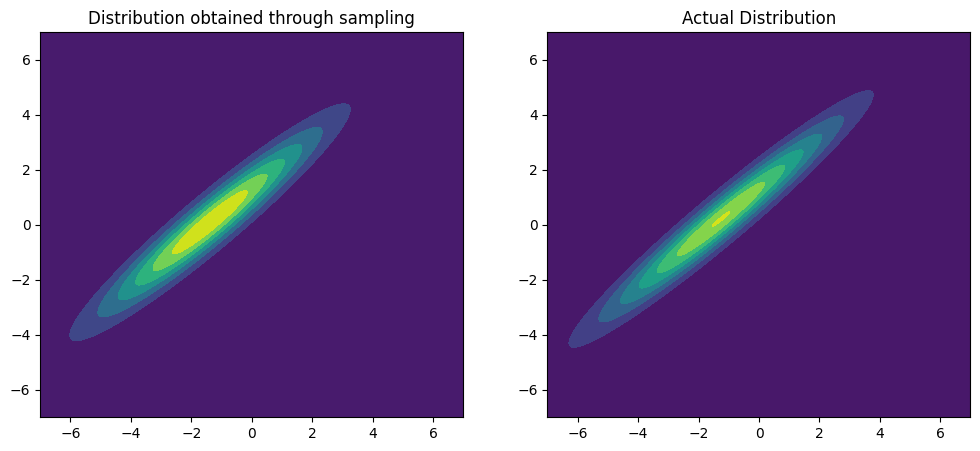

In [8]:
x, y = np.mgrid[-7:7:.01, -7:7:.01]
pos = np.dstack((x, y))

fig, (ax1, ax2) = plt.subplots(figsize=(12, 5), ncols=2)

ax1.contourf(x, y, rv_sampled.pdf(pos))
ax1.set_title("Distribution obtained through sampling")
ax2.contourf(x, y, rv.pdf(pos))
ax2.set_title("Actual Distribution")

plt.show()

In [9]:
kl_divergence(samples, rv)

array([0.39883733])

In [10]:
def sgrnht_sample_multivariate_gaussian_with_covariance(num_samples, theta_init, r_init, eps_init, a, c, d, mu, Sigma, eta_0, burn_in=100, thinning=10):
    """
    SGNHT with added information about riemann information
    
    Parameters:
    - num_samples: Total number of samples to collect after burn-in.
    - theta_init: Initial value for theta.
    - mu: Mean of the Gaussian distribution.
    - Sigma: Covariance matrix of the Gaussian distribution.
    - eta_0: Initial learning rate (step size).
    - burn_in: Number of initial samples to discard (burn-in period).
    - thinning: Save every 'thinning' sample to reduce correlation between samples.
    
    Returns:
    - samples: Collected samples from the target distribution.
    """
    
    # Initialize theta
    theta = theta_init
    r = r_init
    eps = eps_init
    dim = theta.shape[0]  # Dimensionality of theta 
    samples = []
    
    # Precompute the inverse of the covariance matrix Sigma
    Sigma_inv = np.linalg.inv(Sigma)
    
    # Total iterations needed (including burn-in and thinning)
    total_iterations = burn_in + (num_samples * thinning)
    
    for t in range(1, total_iterations + 1):
        # Learning rate schedule (eta_t = eta_0 / t)
        if t % 10 == 0:
            r = np.random.normal(0, 1, size=(2,))
        eta_t = eta_0 
        
        # Calculate U(theta) and gradient of U(theta)
        grad_log_p_theta = np.dot(Sigma_inv, (theta - mu))
        log_p_theta = (theta - mu).T @ Sigma_inv @ (theta - mu)
        
        # Noise term: Gaussian noise with variance proportional to eta_t
        noise = np.random.normal(0, eta_t * 2 * a, size=dim)

        # Calculation of terms related to G
        G_inverse = d * np.sqrt(np.abs(log_p_theta + c))
        G_inverse_root = np.sqrt(G_inverse)
        correction_term = (np.sqrt(d) / 4) * np.power(log_p_theta + c, -3/4) * grad_log_p_theta
        
        # SGLD update step
        theta = theta + (eta_t) * G_inverse_root * r
        r = r - (eta_t) * G_inverse_root * grad_log_p_theta - eta_t * G_inverse * r * eps + correction_term + noise
        #r = np.clip(r, -5, 5)
        eps = eps + eta_t * ((r.T @ r) - 1)/dim
        #eps = np.clip(eps, -5, 5)
        
        # After burn-in, save samples with thinning
        if t > burn_in and (t - burn_in) % thinning == 0:
            samples.append(theta.copy())
            #print(theta)
            
    
    return np.array(samples)

In [11]:
# Parameters for the multivariate Gaussian distribution N(mu, Sigma)
mu = means  # Mean vector (non-zero)
Sigma = covariance_matrix  # Covariance matrix
eta_0 = 0.1  # Initial learning rate
theta_init = np.random.randn(2)  # Start with a 2D random point
r_init = np.random.randn(2)
eps_init = 0
a = 1
c = 0.5
d = 1.5
num_samples = 5000  # Number of samples we want to collect after burn-in

# Run SGLD to sample from N(mu, Sigma)
samples = sgrnht_sample_multivariate_gaussian_with_covariance(num_samples=num_samples, 
                                               theta_init=theta_init,
                                               r_init = r_init,
                                               eps_init = eps_init,
                                               a = a,
                                               c = c,
                                               d = d,
                                               mu=mu, 
                                               Sigma=Sigma, 
                                               eta_0=eta_0,
                                               burn_in=100)

print("Mean of samples:", np.mean(samples, axis=0))
print("Covariance of samples:", np.cov(samples, rowvar=False))

Mean of samples: [-0.96002626  0.46660318]
Covariance of samples: [[8.80133865 7.87145846]
 [7.87145846 7.55639903]]


In [12]:
rv_sampled = multivariate_normal(np.mean(samples, axis=0), np.cov(samples, rowvar=False))

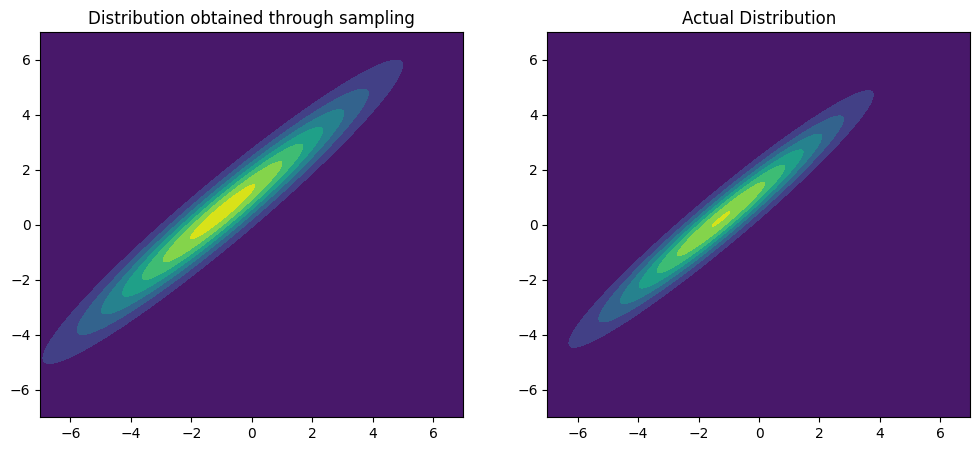

In [13]:
x, y = np.mgrid[-7:7:.01, -7:7:.01]
pos = np.dstack((x, y))

fig, (ax1, ax2) = plt.subplots(figsize=(12, 5), ncols=2)

ax1.contourf(x, y, rv_sampled.pdf(pos))
ax1.set_title("Distribution obtained through sampling")
ax2.contourf(x, y, rv.pdf(pos))
ax2.set_title("Actual Distribution")

plt.show()

In [14]:
kl_divergence(samples, rv)

array([0.26231614])

## Experiments on single mode 1 dimensional normal distribution

In [15]:
# Create the distribution
mean = 3
std_dev = 2

normal_distribution = norm(loc=mean, scale=std_dev)

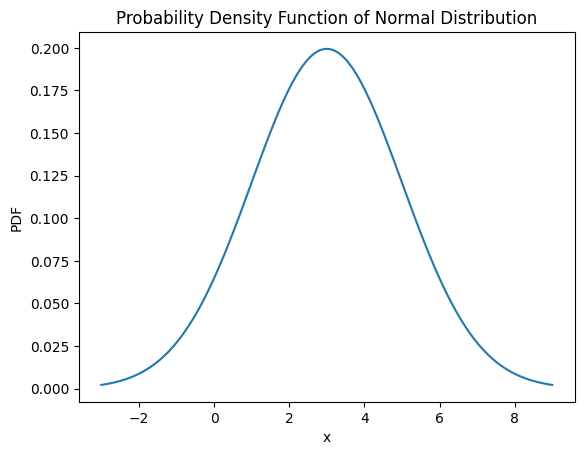

In [16]:
# Plot the distribution
x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 100)

plt.plot(x, normal_distribution.pdf(x))
plt.title('Probability Density Function of Normal Distribution')
plt.xlabel('x')
plt.ylabel('PDF')
plt.show()

In [25]:
def sgnht_sample_univariate(num_samples, theta_init, r_init, eps_init, a, log_p, grad_log_p, eta_0, burn_in=100, thinning=10):
    """
    SGNHT Implementation
    
    Parameters:
    - num_samples: Total number of samples to collect after burn-in.
    - theta_init: Initial value for theta.
    - mu: Mean of the Gaussian distribution.
    - Sigma: Covariance matrix of the Gaussian distribution.
    - eta_0: Initial learning rate (step size).
    - burn_in: Number of initial samples to discard (burn-in period).
    - thinning: Save every 'thinning' sample to reduce correlation between samples.
    
    Returns:
    - samples: Collected samples from the target distribution.
    """
    
    # Initialize theta
    theta = theta_init
    r = r_init
    eps = eps_init
    samples = []
    
    # Total iterations needed (including burn-in and thinning)
    total_iterations = burn_in + (num_samples * thinning)
    
    for t in range(1, total_iterations + 1):
        # Learning rate schedule (eta_t = eta_0 / t)
        eta_t = eta_0 
        
        # Gradient of log p(theta) for multivariate Gaussian N(mu, Sigma)
        grad_log_p_theta = grad_log_p(theta)
        
        # Noise term: Gaussian noise with variance proportional to eta_t
        noise = np.random.normal(0, eta_t * 2 * a, size=1)[0]
        
        # SGLD update step
        theta = theta + (eta_t) * r
        #print(r, (eta_t) * grad_log_p_theta, eta_t * r * eps, noise, (r.T @ r)/dim, (r.T @ r)/dim - 1)
        r = r - (eta_t) * grad_log_p_theta - eta_t * r * eps + noise
        eps = eps + eta_t * ((r * r) - 1)
        #print(r, eps, theta, noise)
        
        # After burn-in, save samples with thinning
        if t > burn_in and (t - burn_in) % thinning == 0:
            samples.append(theta.copy())
            #print(theta)
            
    
    return np.array(samples)

In [56]:
# Set some common initial parameters
eta_0 = 0.1  # Initial learning rate
theta_init = random.random()
r_init = random.random()
eps_init = 0
a = 1
num_samples = 5000  # Number of samples we want to collect after burn-in

log_p = lambda x: (1/2) * (((x - mean) / std_dev) ** 2)
grad_log_p = lambda x: (x - mean) / (std_dev**2)

In [57]:
# Sampling using regular SGNHT
samples_sgnht = sgnht_sample_univariate(num_samples=num_samples, 
                                               theta_init=theta_init,
                                               r_init = r_init,
                                               eps_init = eps_init,
                                               a = a,
                                               log_p = log_p,
                                               grad_log_p = grad_log_p,
                                               eta_0=eta_0,
                                               burn_in=100)

print("Mean of samples:", np.mean(samples_sgnht, axis=0))
print("Covariance of samples:", np.std(samples_sgnht))

Mean of samples: 2.9268218462580755
Covariance of samples: 2.0474665150421325


In [59]:
# Sample using new SGRNHT Algorithm
c = 0.5
d = 1.5

samples_sgrnht = sgrnht_sample_univariate(num_samples=num_samples, 
                                               theta_init=theta_init,
                                               r_init = r_init,
                                               eps_init = eps_init,
                                               a = a,
                                               c = c,
                                               d = d,
                                               log_p = log_p,
                                               grad_log_p = grad_log_p,
                                               eta_0=eta_0,
                                               burn_in=500)

print("Mean of samples:", np.mean(samples_sgrnht, axis=0))
print("Covariance of samples:", np.std(samples_sgrnht))

Mean of samples: 3.0024373476599835
Covariance of samples: 2.0331202786483753


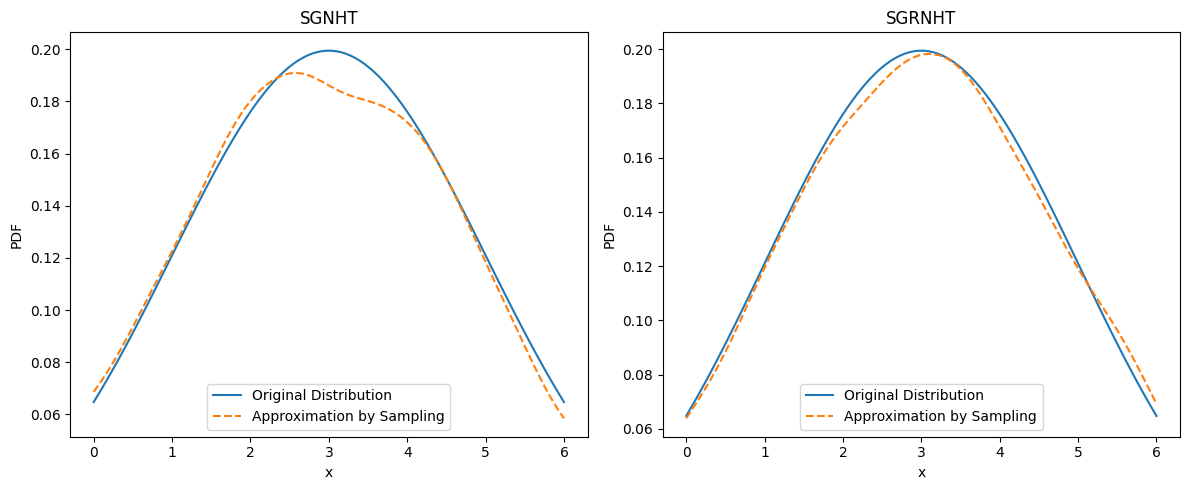

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plot_sampled_distribution(ax[0], normal_distribution, samples_sgnht, custom_dist_mean, custom_dist_std_dev, title='Approximation by SGNHT')
plot_sampled_distribution(ax[1], normal_distribution, samples_sgrnht, custom_dist_mean, custom_dist_std_dev, title='Approximation by SGRNHT')

plt.tight_layout()
plt.legend()
plt.show()

## Experiments on multimodal 1 dimensional pdf

In [23]:
def unnormalized_pdf(x, mean, std_dev):
    return np.exp(-((x-mean)**4 - 2*(x-mean)**2) / (std_dev**2))

def normalized_pdf(x, mean, std_dev):
    normalization_constant, _ = quad(unnormalized_pdf, -np.inf, np.inf, args=(mean, std_dev))
    return unnormalized_pdf(x, mean, std_dev) / normalization_constant

class CustomDist(rv_continuous):
    def __init__(self, mean, std_dev):
        super(CustomDist, self).__init__()
        self.mean = mean
        self.std_dev = std_dev
        
    def _pdf(self, x):
        return normalized_pdf(x, self.mean, self.std_dev)

custom_dist_mean = 3
custom_dist_std_dev = 2
custom_dist = CustomDist(mean=custom_dist_mean, std_dev=custom_dist_std_dev)

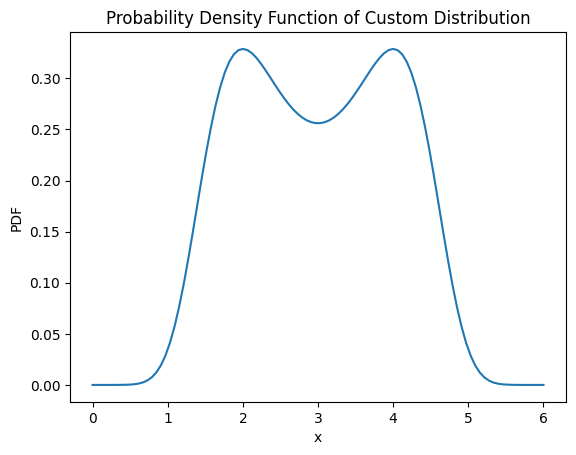

In [24]:
# Plot the distribution
x = np.linspace(custom_dist_mean-1.5*custom_dist_std_dev, custom_dist_mean+1.5*custom_dist_std_dev, 100)

plt.plot(x, custom_dist.pdf(x))
plt.title('Probability Density Function of Custom Distribution')
plt.xlabel('x')
plt.ylabel('PDF')
plt.show()

In [26]:
def sgrnht_sample_univariate(num_samples, theta_init, r_init, eps_init, a, c, d, log_p, grad_log_p, eta_0, burn_in=100, thinning=10):
    """
    SGNHT with added information about riemann information
    
    Parameters:
    - num_samples: Total number of samples to collect after burn-in.
    - theta_init: Initial value for theta.
    - mu: Mean of the Gaussian distribution.
    - Sigma: Covariance matrix of the Gaussian distribution.
    - eta_0: Initial learning rate (step size).
    - burn_in: Number of initial samples to discard (burn-in period).
    - thinning: Save every 'thinning' sample to reduce correlation between samples.
    
    Returns:
    - samples: Collected samples from the target distribution.
    """
    
    # Initialize theta
    theta = theta_init
    r = r_init
    eps = eps_init
    samples = []
    
    
    # Total iterations needed (including burn-in and thinning)
    total_iterations = burn_in + (num_samples * thinning)
    
    for t in range(1, total_iterations + 1):
        # Learning rate schedule (eta_t = eta_0 / t)
        eta_t = eta_0 
        
        # Calculate U(theta) and gradient of U(theta)
        grad_log_p_theta = grad_log_p(theta)
        log_p_theta = log_p(theta)
        
        # Noise term: Gaussian noise with variance proportional to eta_t
        noise = np.random.normal(0, eta_t * 2 * a, size=1)[0]

        # Calculation of terms related to G
        G_inverse = d * np.sqrt(np.abs(log_p_theta + c))
        G_inverse_root = np.sqrt(G_inverse)
        correction_term = (np.sqrt(d) / 4) * np.power(log_p_theta + c, -3/4) * grad_log_p_theta

        #print(eps, r, theta, G_inverse, G_inverse_root, correction_term)

        #print(noise.shape, G_inverse.shape, G_inverse_root.shape, correction_term.shape)
        
        # update step
        theta = theta + (eta_t) * G_inverse_root * r
        r = r - (eta_t) * G_inverse_root * grad_log_p_theta - eta_t * G_inverse * r * eps + eta_t * correction_term + noise
        eps = eps + eta_t * ((r * r) - 1)
        
        # After burn-in, save samples with thinning
        if t > burn_in and (t - burn_in) % thinning == 0:
            samples.append(theta.copy())
            #print(theta)
            
    
    return np.array(samples)

In [27]:
# Set some common initial parameters
eta_0 = 0.05  # Initial learning rate
theta_init = random.random()
r_init = random.random()
eps_init = 0
a = 5
num_samples = 15000  # Number of samples we want to collect after burn-in
log_p = lambda x: ((x-custom_dist_mean)**4 - 2*(x-custom_dist_mean)**2) / (custom_dist_std_dev**2)
grad_log_p = lambda x: (4 * ((x-custom_dist_mean)**3) - 4 * (x-custom_dist_mean)) / (custom_dist_std_dev**2)

In [28]:
# Sampling using regular SGNHT
samples_sgnht = sgnht_sample_univariate(num_samples=num_samples, 
                                               theta_init=theta_init,
                                               r_init = r_init,
                                               eps_init = eps_init,
                                               a = a,
                                               log_p = log_p,
                                               grad_log_p = grad_log_p,
                                               eta_0=eta_0,
                                               burn_in=500)

print("Mean of samples:", np.mean(samples_sgnht, axis=0))
print("Standard Deviation of samples:", np.std(samples_sgnht))

Mean of samples: 2.976224942698591
Standard Deviation of samples: 1.0157565909905133


In [47]:
# Sample using new SGRNHT Algorithm
c = 0.5
d = 1.5

samples_sgrnht = sgrnht_sample_univariate(num_samples=num_samples, 
                                               theta_init=theta_init,
                                               r_init = r_init,
                                               eps_init = eps_init,
                                               a = a,
                                               c = c,
                                               d = d,
                                               log_p = log_p,
                                               grad_log_p = grad_log_p,
                                               eta_0=eta_0,
                                               burn_in=3000)

print("Mean of samples:", np.mean(samples_sgrnht, axis=0))
print("Covariance of samples:", np.std(samples_sgrnht))

Mean of samples: 3.0232969901894675
Covariance of samples: 1.014697623938395


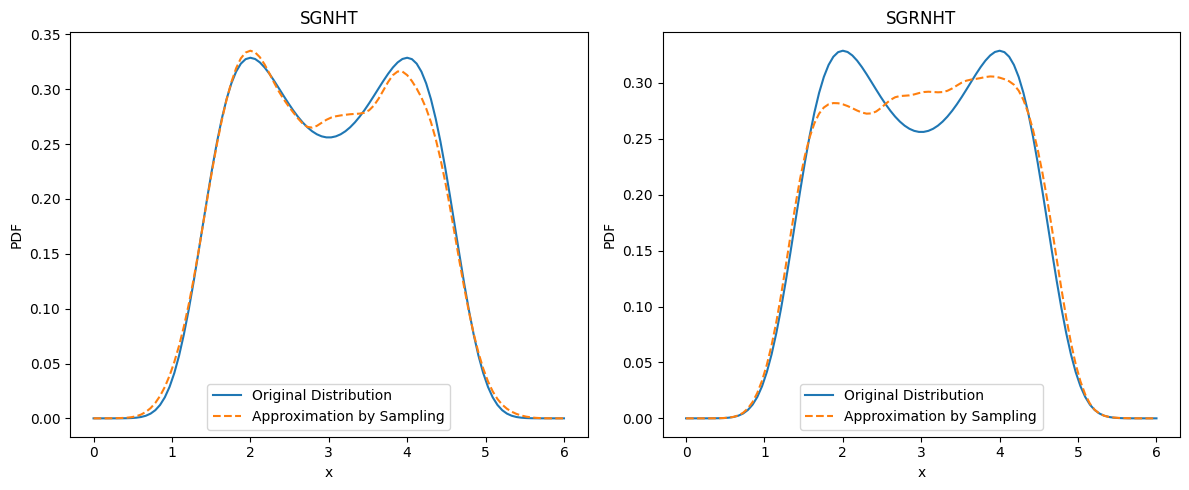

In [55]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

plot_sampled_distribution(ax[0], custom_dist, samples_sgnht, custom_dist_mean, custom_dist_std_dev, title='Approximation by SGNHT')
plot_sampled_distribution(ax[1], custom_dist, samples_sgrnht, custom_dist_mean, custom_dist_std_dev, title='Approximation by SGRNHT')

plt.legend()
plt.tight_layout()
plt.show()

In [52]:
kl_divergence(samples_sgnht, custom_dist)

4076.2721168620437


np.float64(0.0021835556991223275)

In [53]:
kl_divergence(samples_sgrnht, custom_dist)

4034.5265650356955


np.float64(0.0043458694582912466)